In [1]:
import os
import sys
HOME = os.path.abspath('..')
sys.path.append(HOME)
os.chdir(HOME)

In [2]:
import torchvision
import dlib
from PIL import Image
from imutils import face_utils
from src.data.dataprep_mediapipe import *
from src.data.imgutils import *
from src.features.features_extractors_mediapipe import *
import pandas as pd
import seaborn as sns

In [3]:
HOME

'/Users/samirchar/Google_Drive/Masters/DSI Scholars/stroke_detection'

In [45]:
DUMMY_DATA_PATH = 'data/dummy_data/'
DUMMY_DATA_2_PATH = DUMMY_DATA_PATH+'samir/'
#video = torchvision.io.read_video('data/raw/29_face_smile.mov')
video = torchvision.io.read_video(DUMMY_DATA_2_PATH+'face_smile_sequence.mp4')

/opt/anaconda3/lib/python3.7/site-packages/torchvision/io/video.py:106: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results and will be removed in a " +


In [50]:
FPS = video[2]['video_fps']
frames = video[0].transpose(1,2)
num_frames,H,W,C = frames.size()
print(num_frames)

496


In [51]:
vertical_flip = True

if vertical_flip:
    frames = [cv2.flip(i.numpy(), 0) for i in frames]
    
else:
    frames = [i.numpy() for i in frames]
    

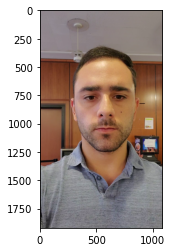

In [52]:
plt.imshow(frames[0])

In [53]:
'''
left_magnitudes_temp_flipped = [cv2.flip(i,1) for i in left_magnitudes_temp]

right_magnitudes_temp_cropped = []
for i in range(len(left_magnitudes_temp_flipped)):
    hlf,wlf = left_magnitudes_temp_flipped[i].shape
    hrf,wrf = right_magnitudes_temp[i].shape
    h_i = min(hlf,hrf)
    w_i = min(wlf,wrf)
    
    right_magnitudes_temp_cropped.append(right_magnitudes_temp[i][:h_i,:w_i])

bilateral_differences = [l-r for l,r in zip(left_magnitudes_temp_flipped,right_magnitudes_temp_cropped)]
'''

'\nleft_magnitudes_temp_flipped = [cv2.flip(i,1) for i in left_magnitudes_temp]\n\nright_magnitudes_temp_cropped = []\nfor i in range(len(left_magnitudes_temp_flipped)):\n    hlf,wlf = left_magnitudes_temp_flipped[i].shape\n    hrf,wrf = right_magnitudes_temp[i].shape\n    h_i = min(hlf,hrf)\n    w_i = min(wlf,wrf)\n    \n    right_magnitudes_temp_cropped.append(right_magnitudes_temp[i][:h_i,:w_i])\n\nbilateral_differences = [l-r for l,r in zip(left_magnitudes_temp_flipped,right_magnitudes_temp_cropped)]\n'

# Run all Video V2

In [54]:
import cv2
import time
import uuid 
#Constants
SIZE = 256
OPTICAL_FLOW_THRESHOLD = 3
SAVE_VIDEO = True

#Init
selected_landmarks = -1
op = OpticalFlow(flow_threshold = OPTICAL_FLOW_THRESHOLD)
op_face = OpticalFlow(flow_threshold = OPTICAL_FLOW_THRESHOLD)
ofs = OpticalFlowSymmetry()                  
rfev2 = ROIFlowExtractorV2(OPTICAL_FLOW_THRESHOLD)

uuid_ = str(uuid.uuid1()).split('-')[0]

frame_prev = frames[0]
original_frames = [frame_prev]
h,w,_ = frame_prev.shape
detector = FaceMeshDetector(frame_height=h,
                            frame_width=w,
                            desiredFaceWidthHeight= (SIZE,SIZE),
                            yaw_correction=True)


frame_prev,faces_prev = detector.process(frame_prev)
face_prev = faces_prev[0]
gray_frame_prev = cv2.cvtColor(frame_prev, cv2.COLOR_RGB2GRAY)
frame_drawn_prev = detector.draw_faces(frame_prev,faces_prev)
processed_landmarks_prev = face_prev['processed_landmarks']

of_temp = []
left_movement_temp = []
right_movement_temp = []
left_magnitudes_temp = []
right_magnitudes_temp = []
num_frames = 0
time_start = time.time()

left_of_frames = []
right_of_frames = []
frames_drawn = []
all_face_objs = []

#OF first, then crop
lm_scores = []
rm_scores = [] 

face_mags = []
face_mags_filtered = []

for frame in frames:
    
    frame,faces = detector.process(frame)
    face = faces[0]
    
    all_face_objs.append(face)
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame_drawn = detector.draw_faces(frame,faces)
    processed_landmarks = face['processed_landmarks']

    
    #OF Movement V2:
    rfev2.face_flow(frame_prev,frame)
    rfev2.all_regions_movement(processed_landmarks,['mouth'])

    
    #Append to temporal lists
    of_temp.append(of_mouth_symmetry_score)
    right_movement_temp.append(right_movement_score)
    left_movement_temp.append(left_movement_score)
    right_magnitudes_temp.append(right_magnitude)
    left_magnitudes_temp.append(left_magnitude)

    data_annotator = annotate_data(initial_h=int(frame.shape[0]*.1), interval_h=int(frame.shape[0]*.1))
    #frame_drawn = data_annotator.annotate(frame_drawn,'b_asymmetry',round(barycentric_asymmetry,2)) 
    frame_drawn = data_annotator.annotate(frame_drawn,
                                          'mouth_of_abs_diff',
                                           round(abs(rfev2.regions_movement['mouth']['left'][-1]-\
                                                    rfev2.regions_movement['mouth']['right'][-1]),2)
                                               ) 
    
    frame_drawn = cv2.cvtColor(frame_drawn, cv2.COLOR_RGB2BGR)
        
    frames_drawn.append(frame_drawn)
    
    num_frames+=1
    cv2.imshow('Input', frame_drawn)

    c = cv2.waitKey(1)
    if c == 27:
        break
       
    # Updates previous frame info
    frame_prev = frame
    gray_frame_prev = gray_frame 
    frame_drawn_prev,face_prev = frame_drawn,face
    processed_landmarks_prev = processed_landmarks

    

In [55]:
bac = BarycentricAsymmetryCalculator()

landmarks_sequence = [i['processed_landmarks_normalized'] for i in all_face_objs]
asymmetry_index_df = bac.get_indexes_video(landmarks_sequence)
asymmetry_stats = bac.get_indexes_stats_video(asymmetry_index_df)
asymmetry_stats

,mouth,eyebrows
0.1,0.100426,0.002643
0.2,0.185790,0.003331
0.3,0.252387,0.004160
0.4,0.316649,0.005238
0.5,0.389633,0.006389
0.6,0.487080,0.007727


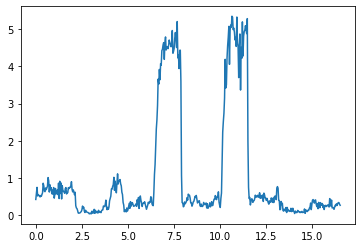

In [56]:
plt.plot(np.arange(len(asymmetry_index_df))/FPS,asymmetry_index_df['mouth'])

In [57]:
movement_df = rfev2.to_df()

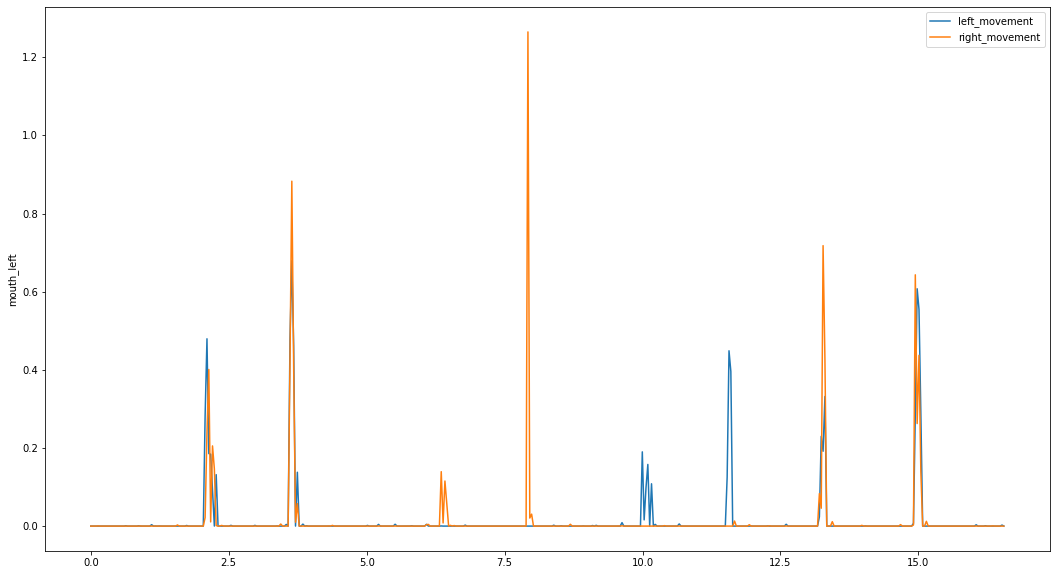

In [58]:
plt.figure(figsize = (18,10))

t = np.arange(len(movement_df))/FPS
sns.lineplot(x=t,y=movement_df['mouth_left'],label = 'left_movement')
sns.lineplot(x=t,y=movement_df['mouth_right'],label = 'right_movement')
plt.legend()
#plt.xlim(4,6)
plt.show()

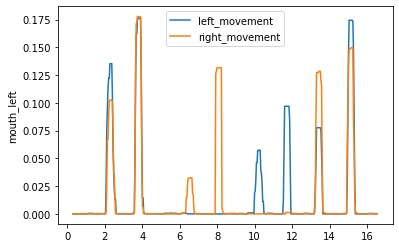

In [59]:
sns.lineplot(x=t,y=movement_df['mouth_left'].rolling(10).mean(),label = 'left_movement')
sns.lineplot(x=t,y=movement_df['mouth_right'].rolling(10).mean(),label = 'right_movement')
plt.legend()
plt.show()

In [60]:
movement_df.apply(lambda x: x[x>0].describe())

,mouth_left,mouth_right
count,67.000000,57.000000
mean,0.108216,0.127656
std,0.175785,0.250517
min,0.000059,0.000054
25%,0.000842,0.001344
50%,0.004397,0.008034
75%,0.170848,0.139208
max,0.679319,1.264995


In [61]:
movement_df.apply(lambda x: x.describe())

,mouth_left,mouth_right
count,496.000000,496.000000
mean,0.014618,0.014670
std,0.074101,0.093600
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,0.679319,1.264995


# Save Videos

In [138]:

#Save Videos
video_name = f'data/created_videos/processed_video_{uuid_}.avi'
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')

video_r = cv2.VideoWriter(video_name,fourcc, FPS, (256,256))

if SAVE_VIDEO:
    for i in face_mags:
        video_r.write(cv2.cvtColor(i.round().astype('uint8'),cv2.COLOR_GRAY2BGR))
        


In [148]:
num_frames*FPS/len(face_mags),FPS

(29.911251227038054, 29.911251227038054)

In [153]:
frames[0].shape

(1920, 1080, 3)

In [140]:
cv2.cvtColor(i.round().astype('uint8'),cv2.COLOR_GRAY2BGR).shape

(256, 256, 3)

In [111]:
cv2.cvtColor(i.round().astype('uint8'),cv2.COLOR_GRAY2BGR).shape

(256, 256, 3)

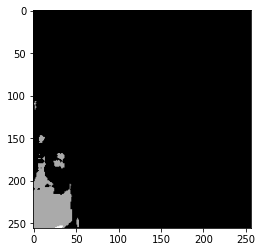

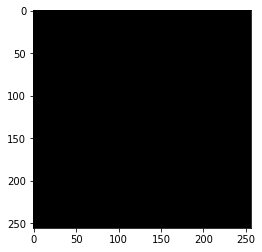

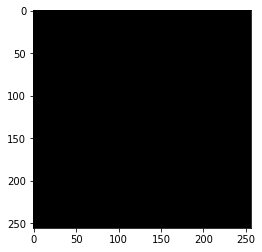

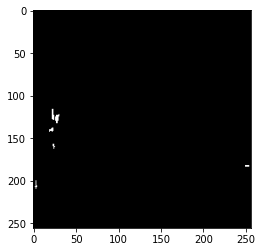

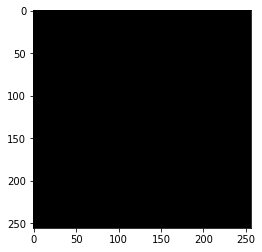

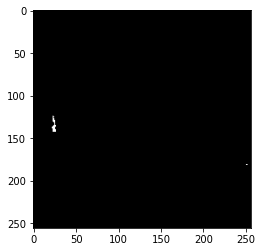

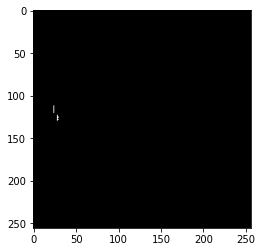

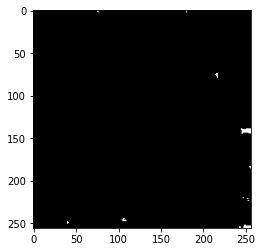

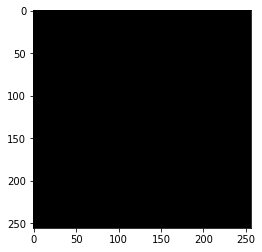

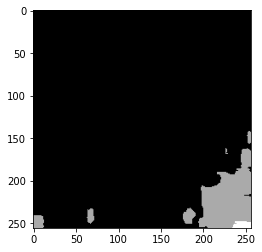

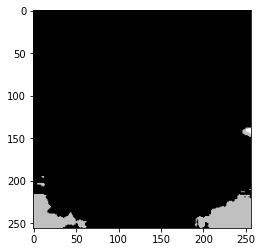

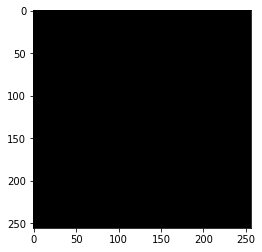

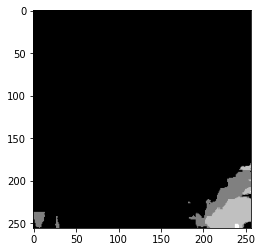

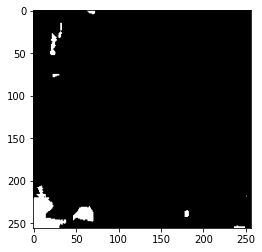

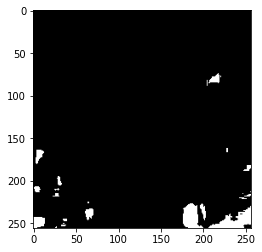

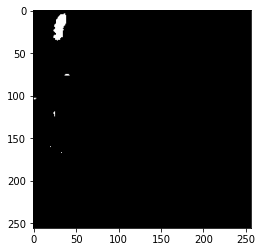

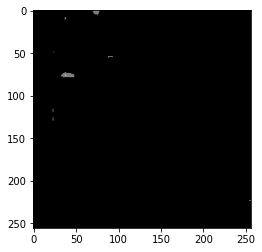

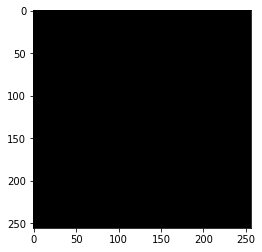

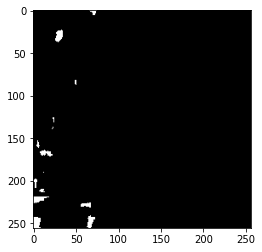

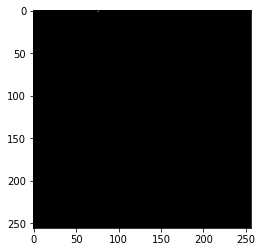

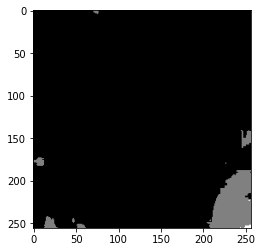

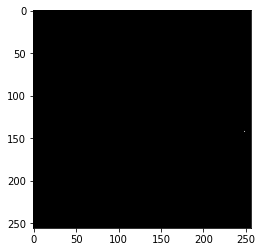

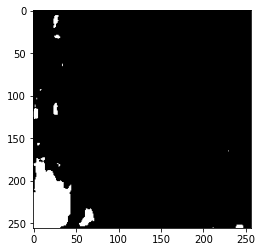

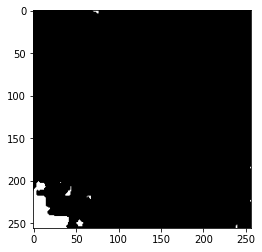

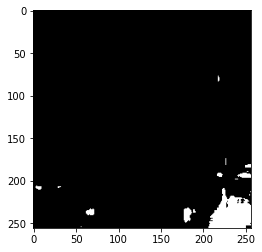

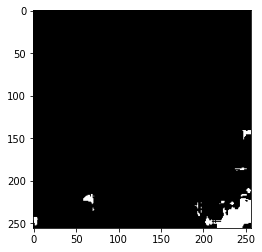

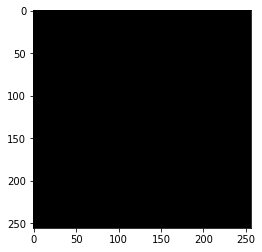

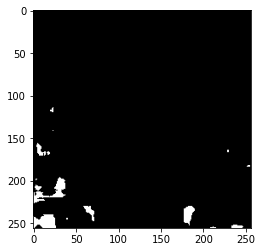

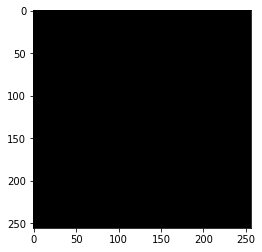

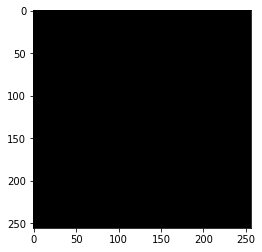

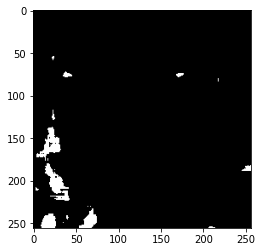

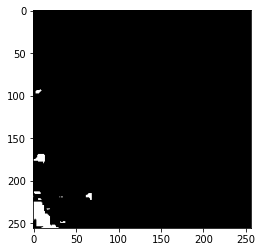

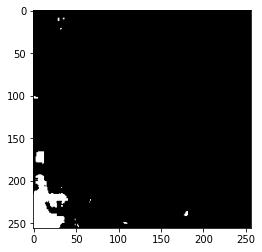

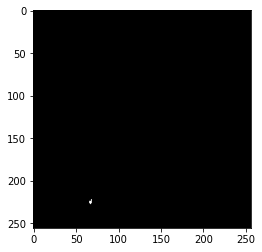

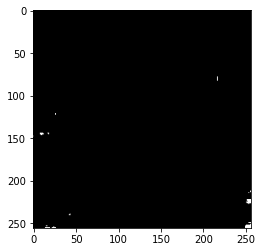

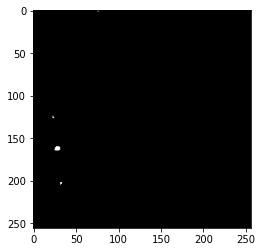

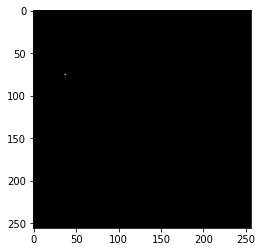

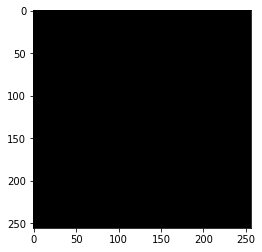

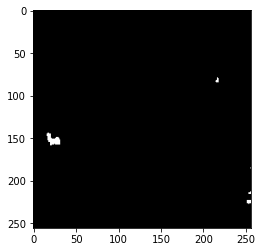

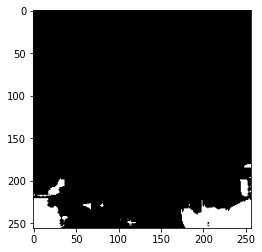

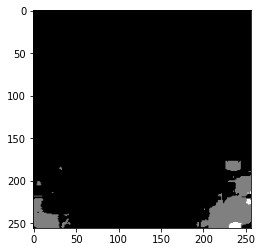

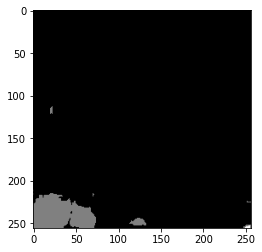

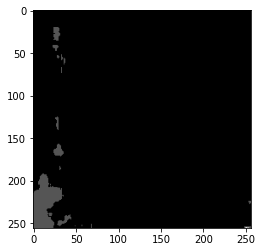

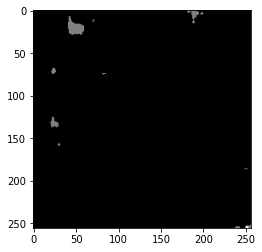

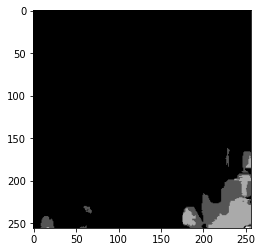

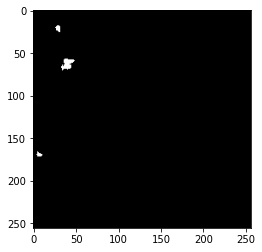

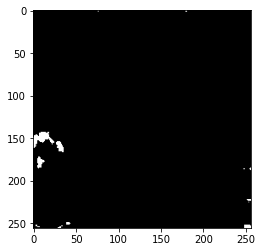

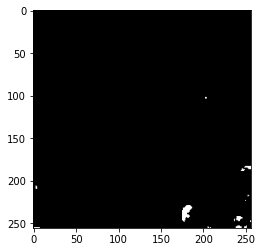

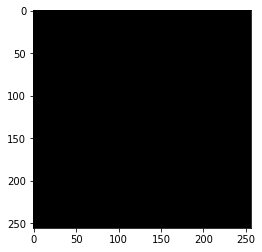

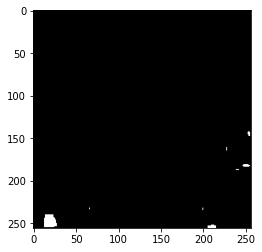

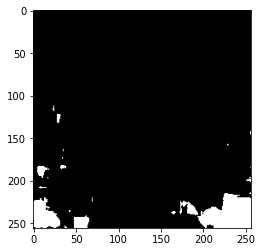

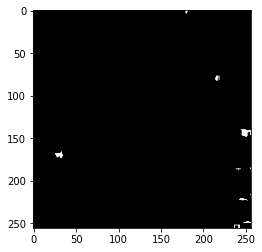

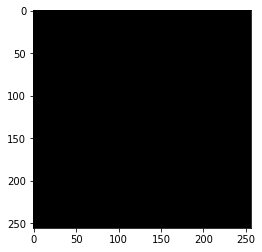

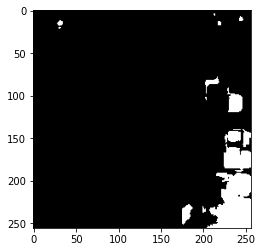

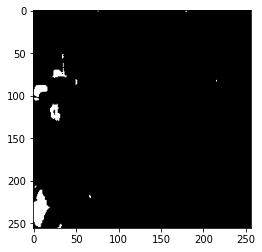

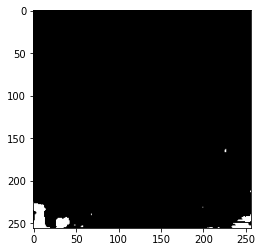

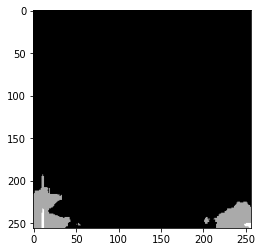

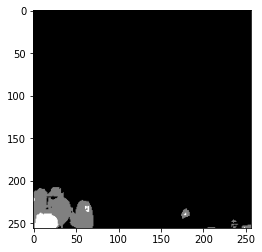

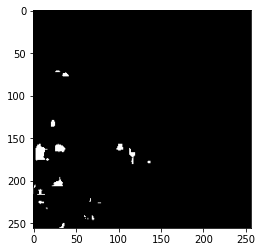

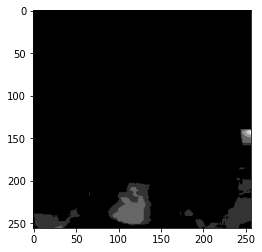

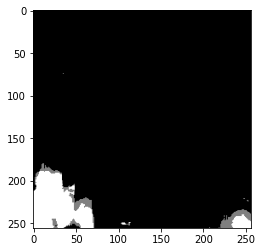

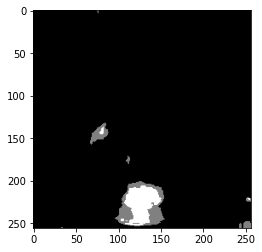

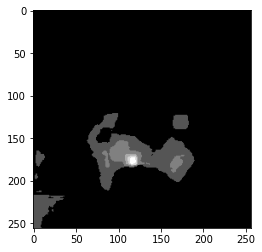

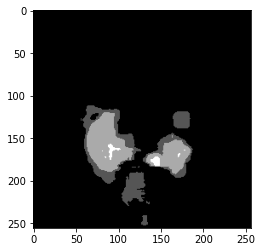

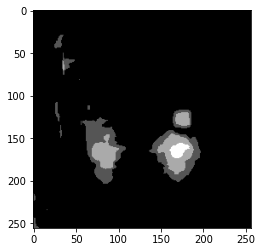

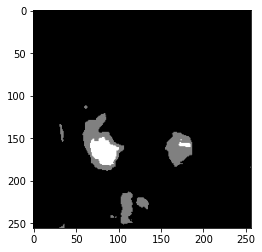

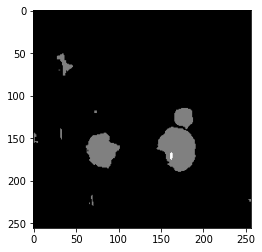

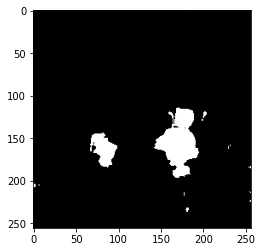

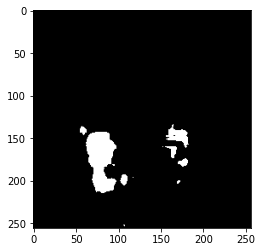

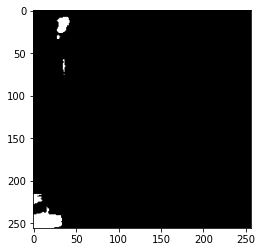

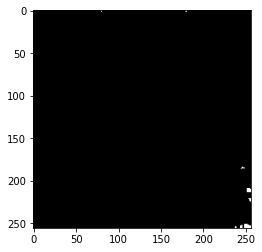

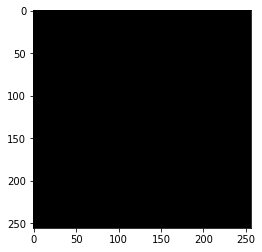

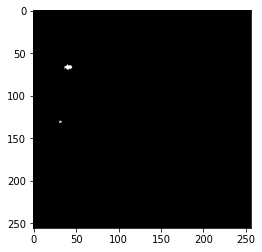

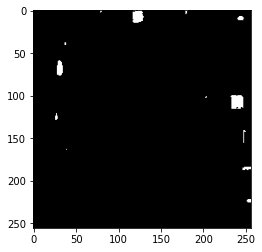

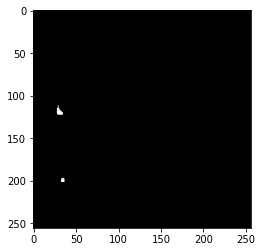

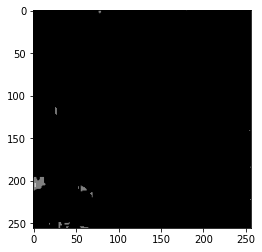

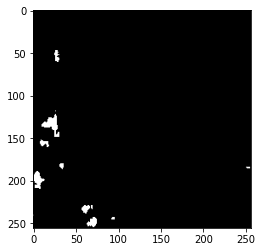

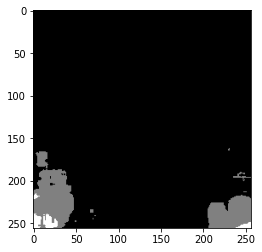

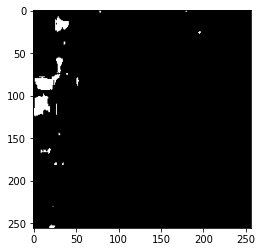

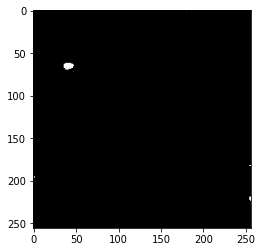

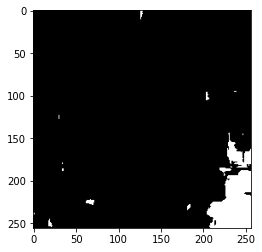

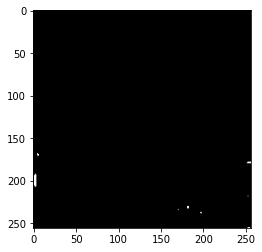

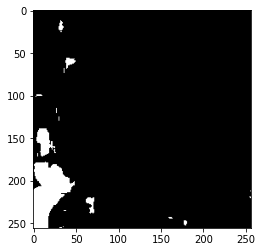

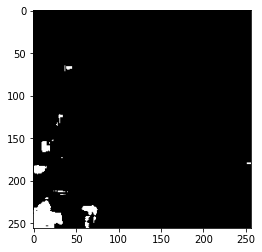

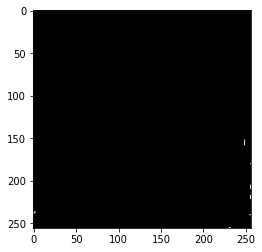

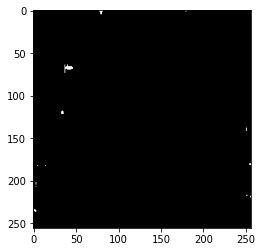

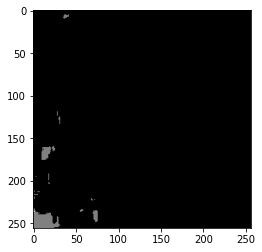

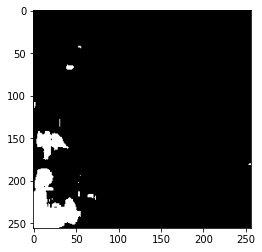

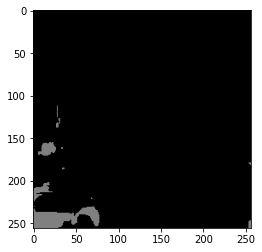

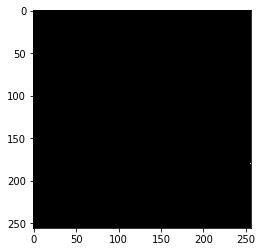

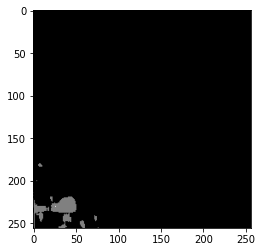

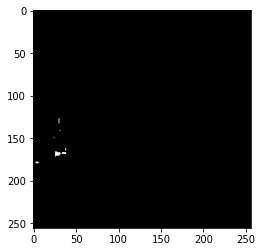

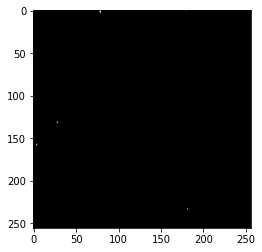

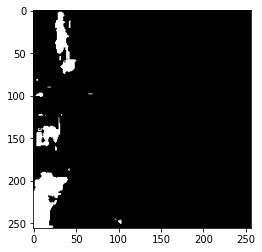

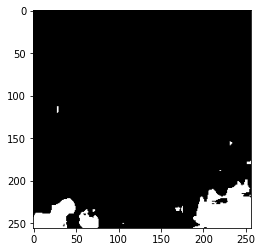

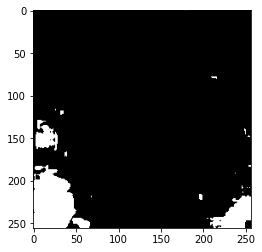

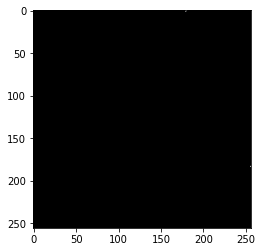

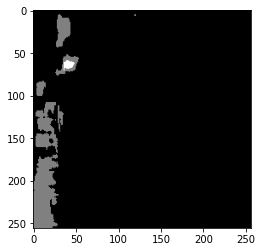

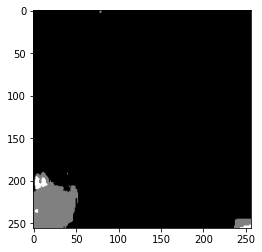

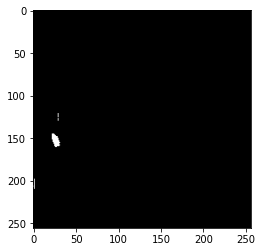

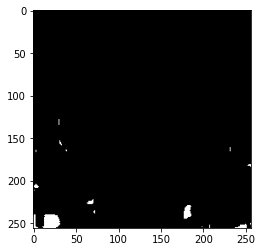

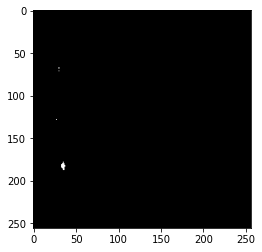

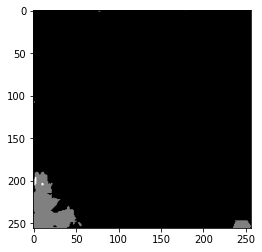

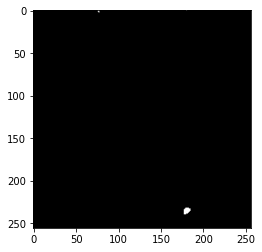

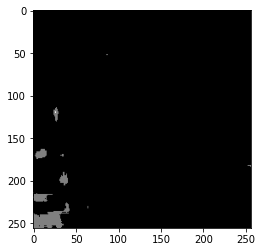

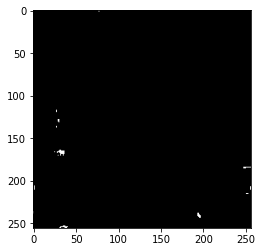

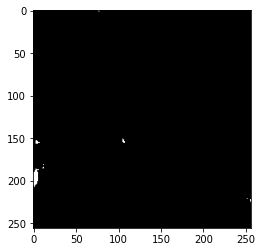

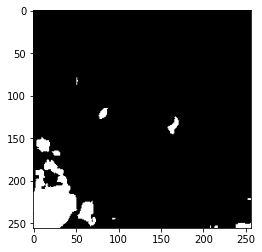

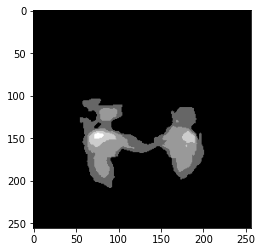

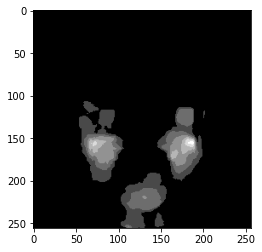

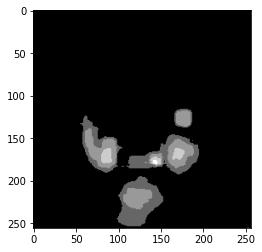

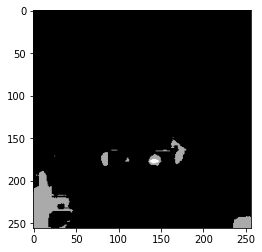

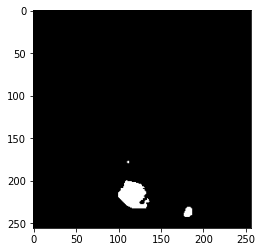

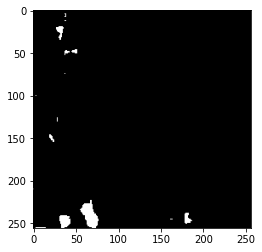

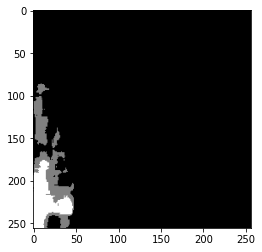

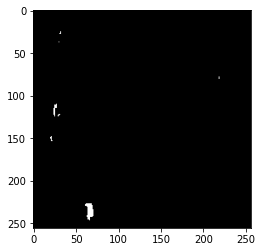

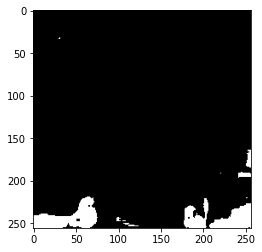

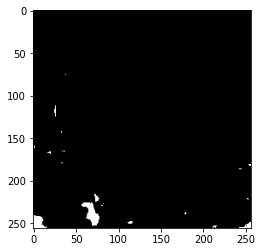

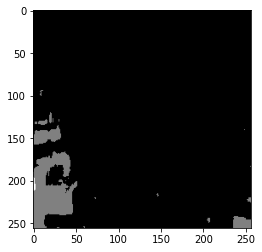

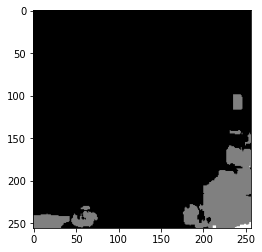

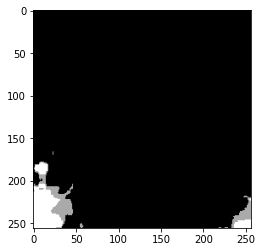

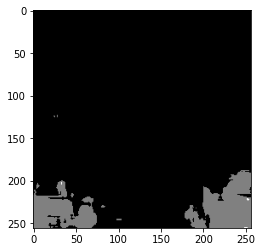

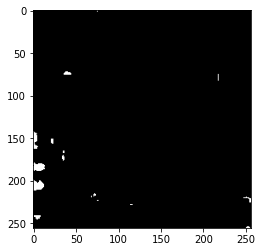

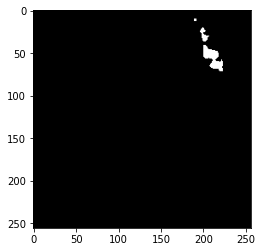

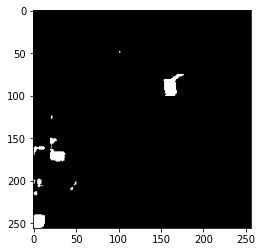

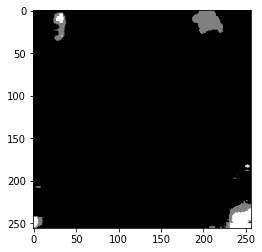

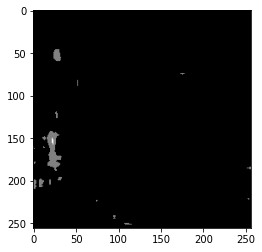

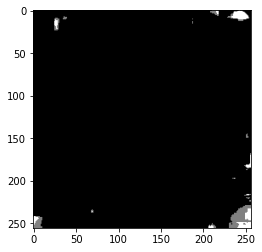

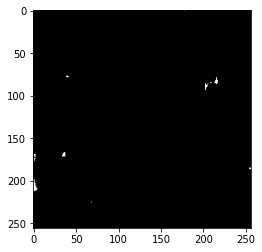

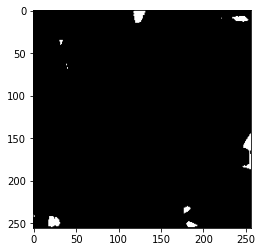

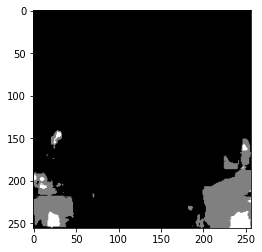

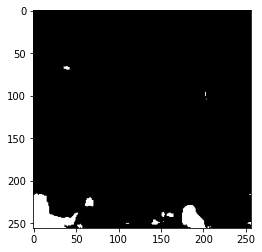

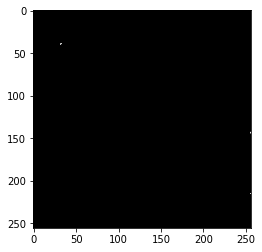

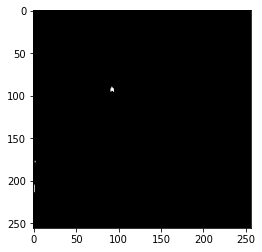

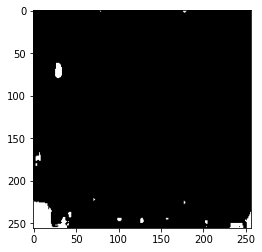

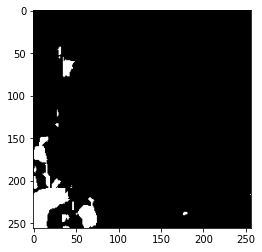

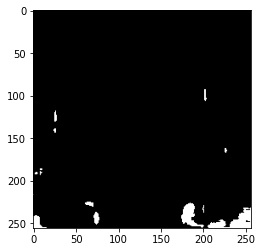

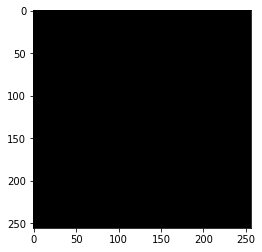

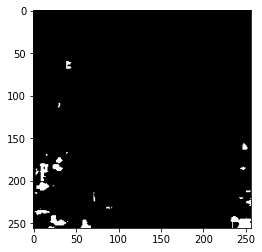

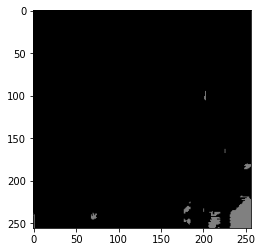

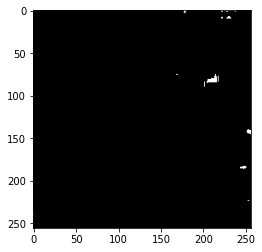

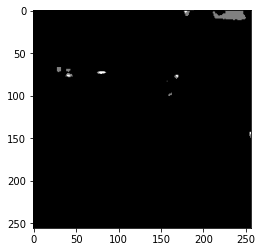

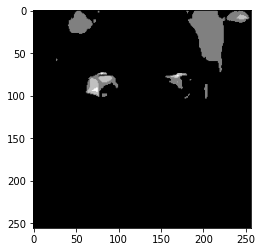

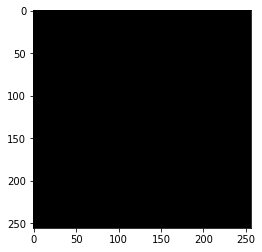

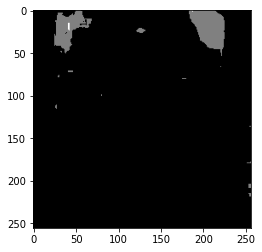

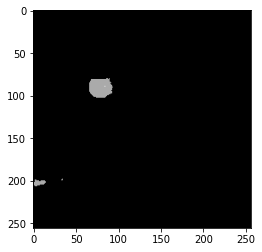

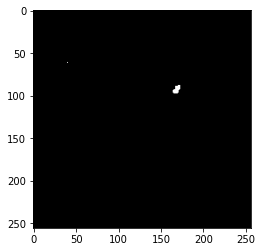

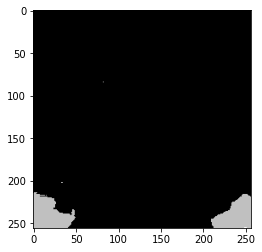

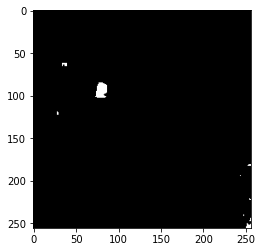

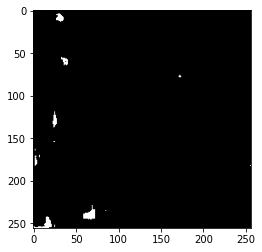

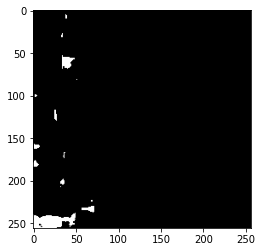

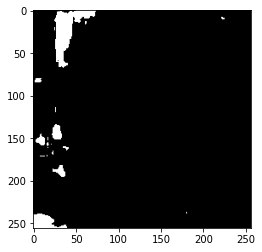

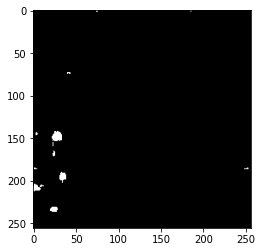

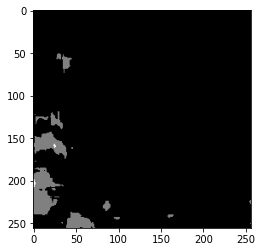

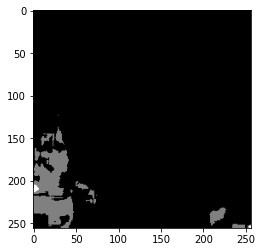

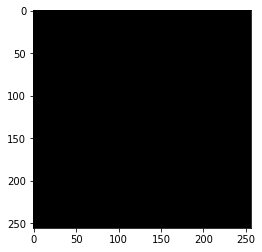

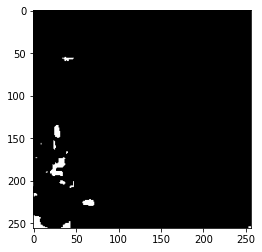

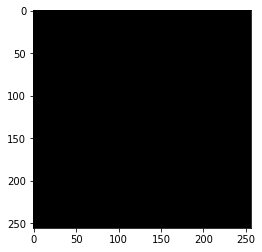

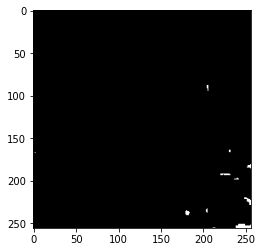

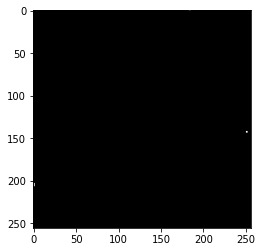

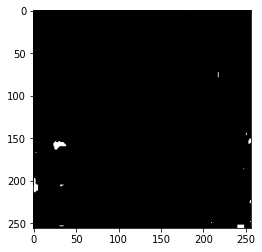

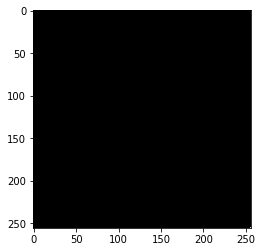

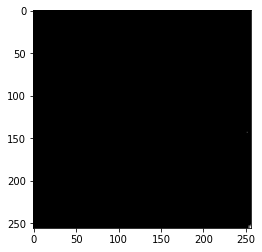

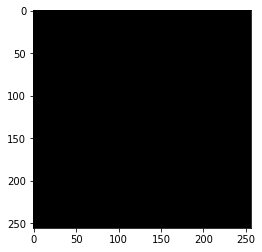

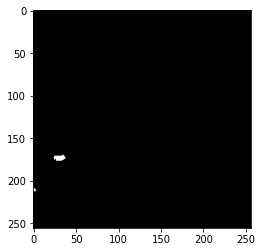

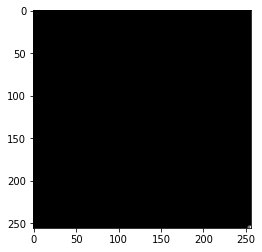

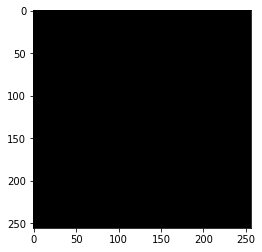

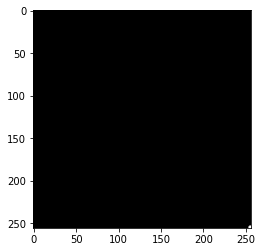

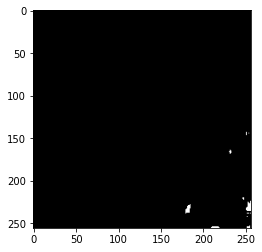

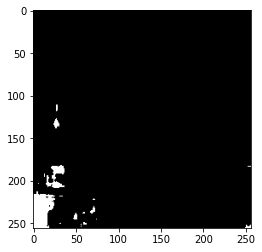

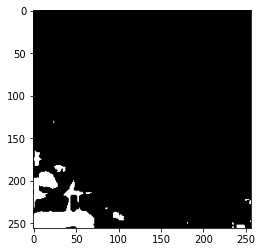

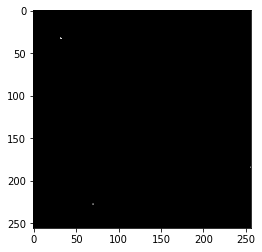

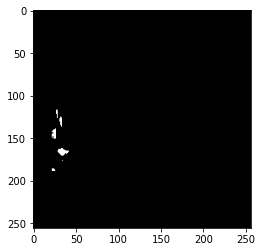

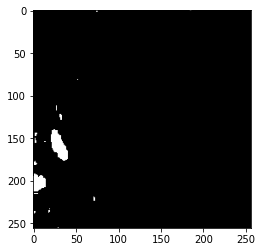

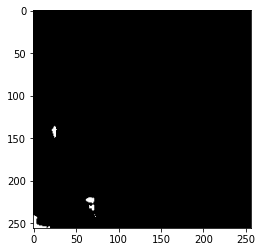

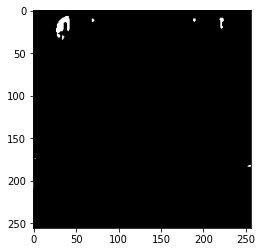

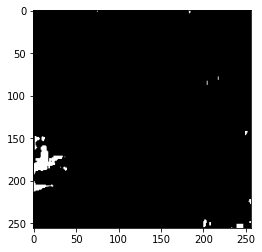

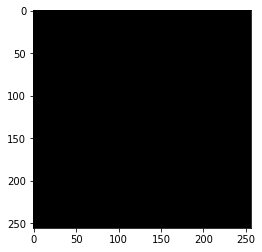

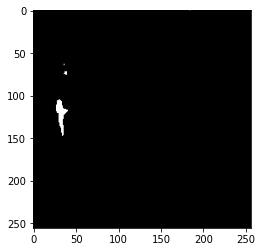

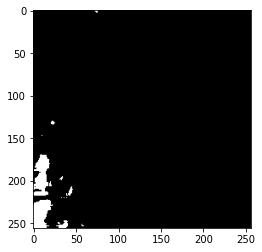

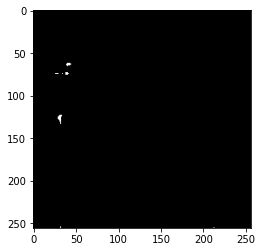

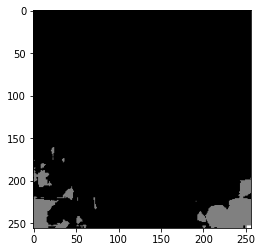

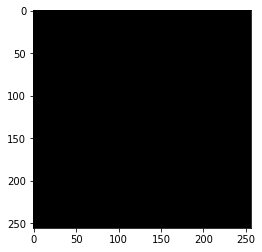

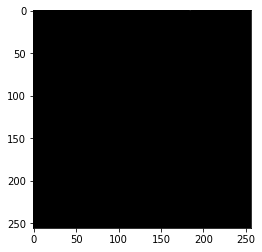

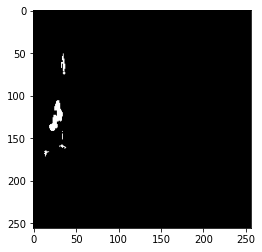

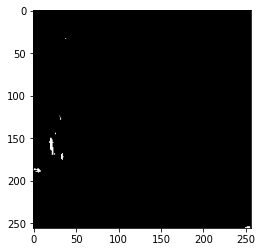

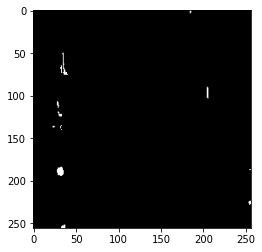

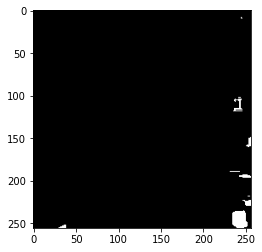

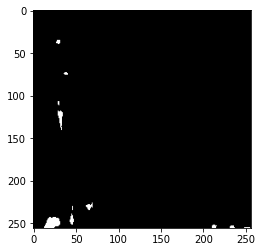

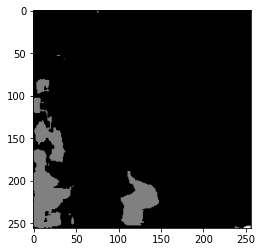

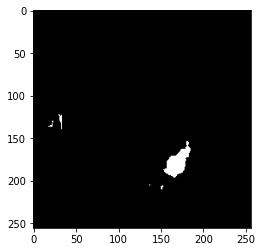

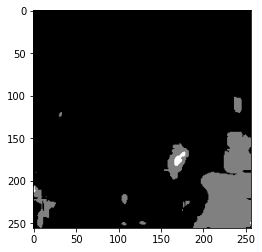

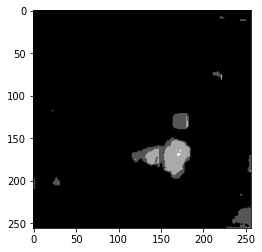

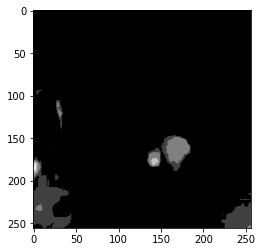

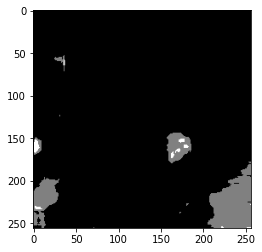

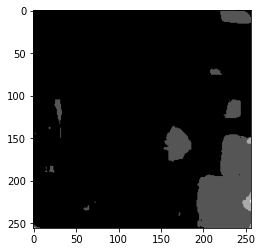

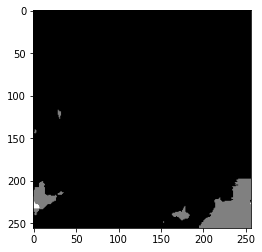

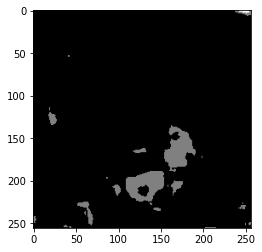

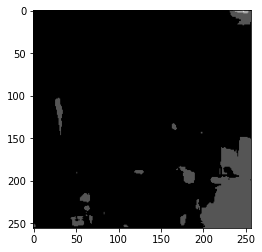

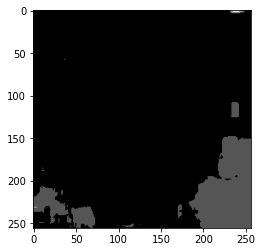

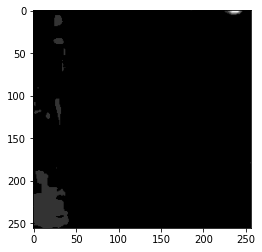

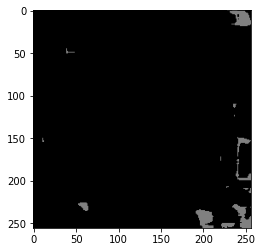

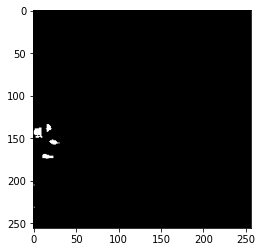

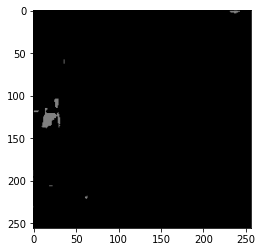

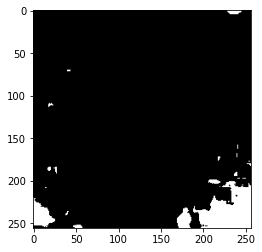

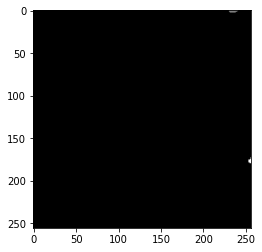

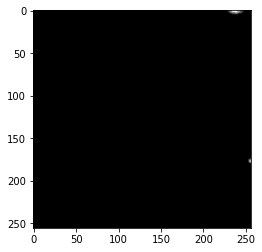

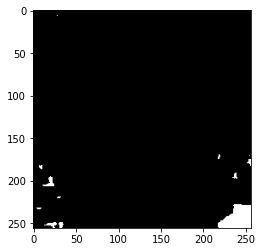

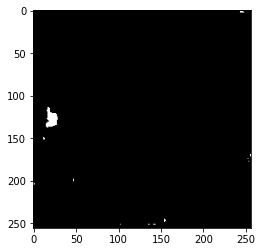

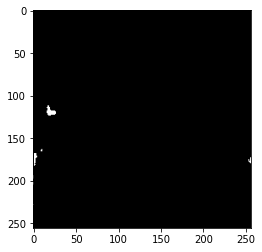

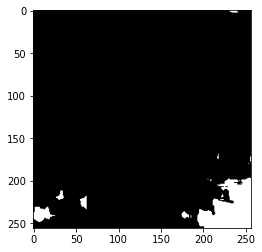

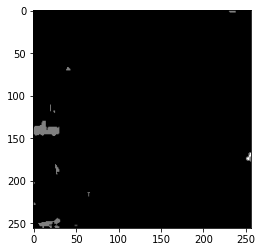

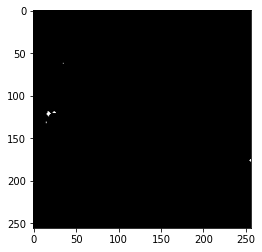

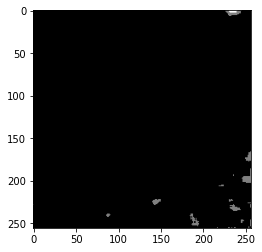

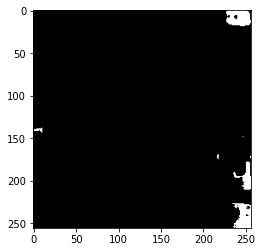

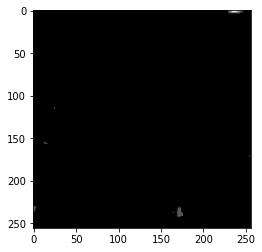

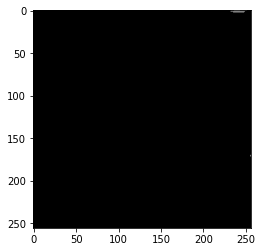

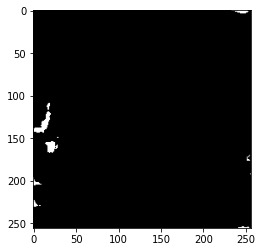

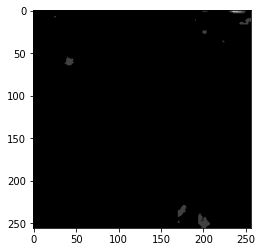

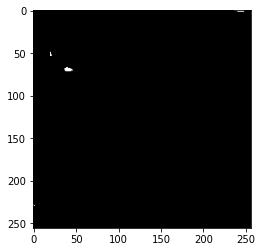

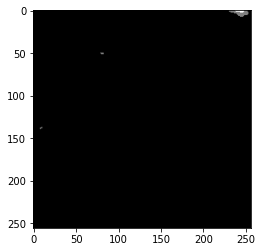

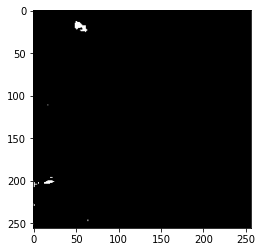

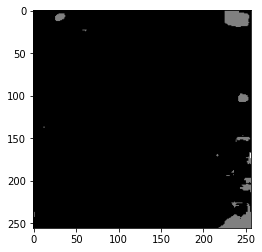

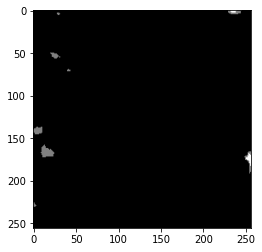

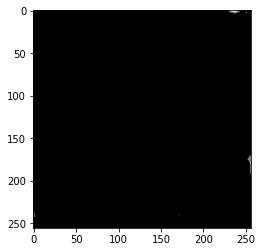

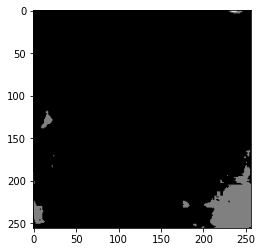

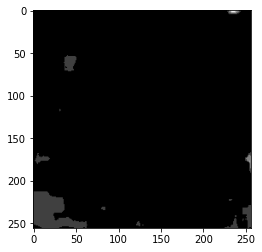

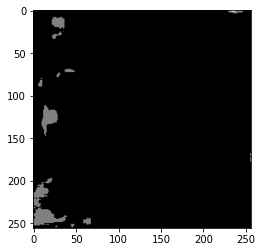

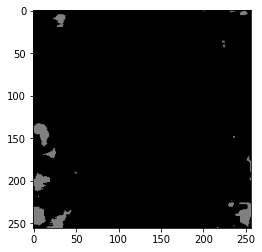

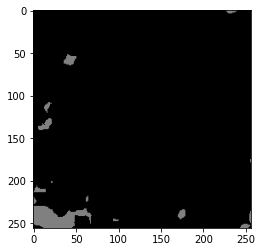

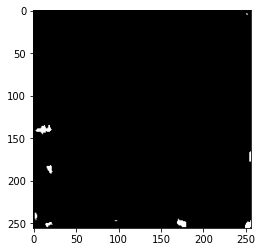

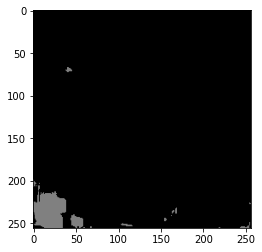

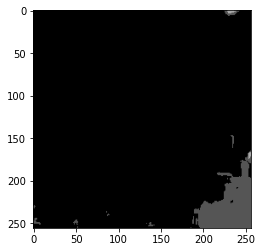

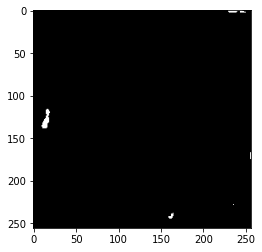

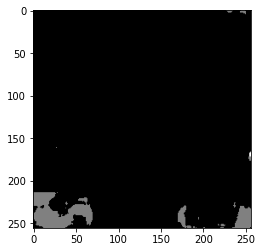

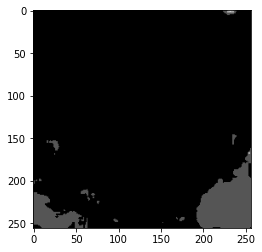

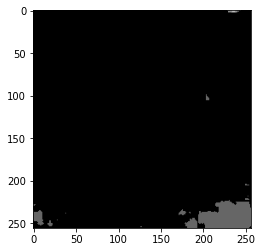

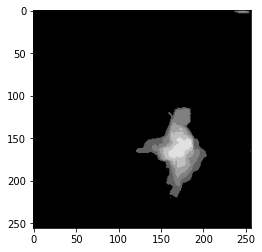

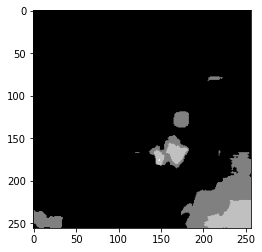

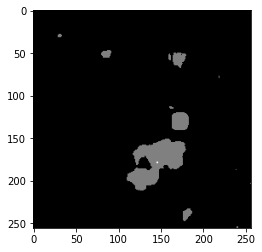

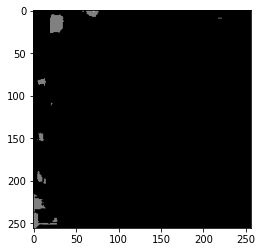

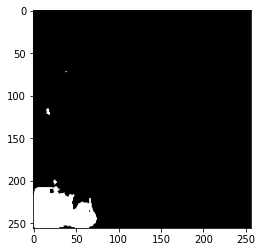

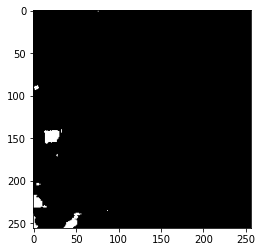

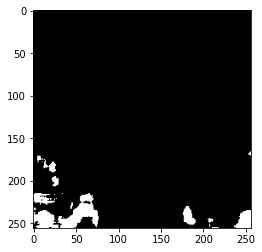

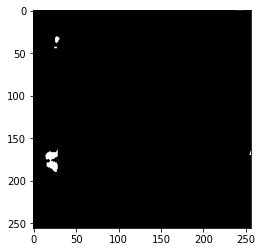

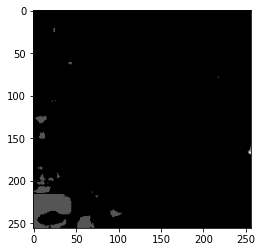

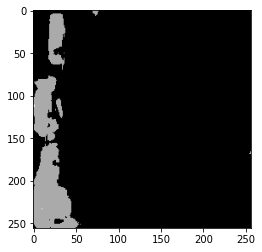

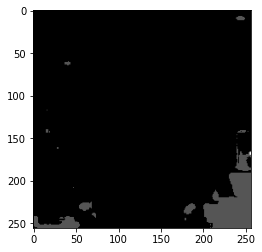

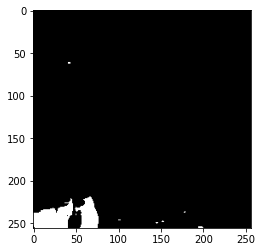

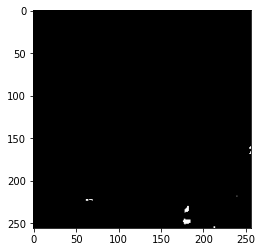

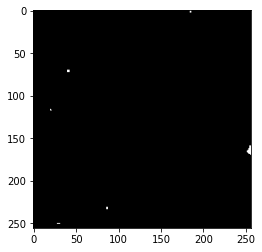

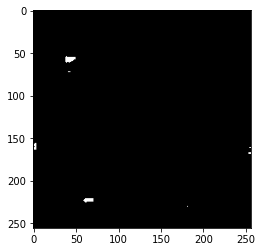

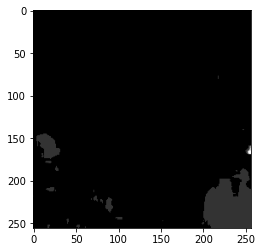

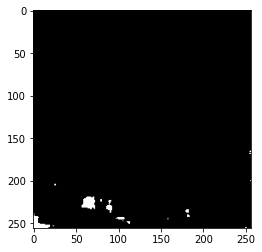

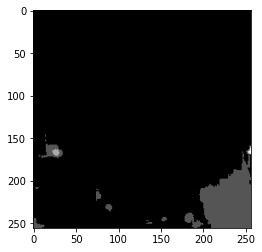

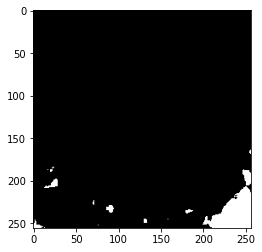

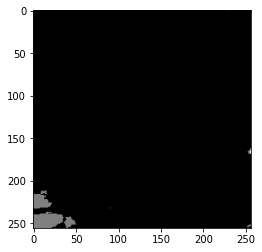

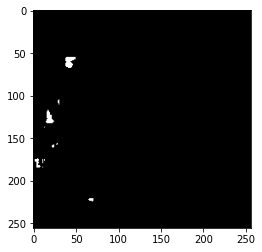

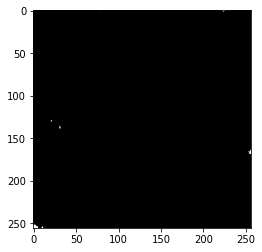

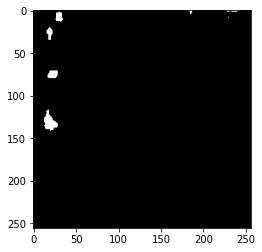

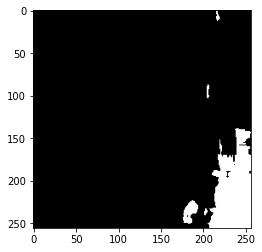

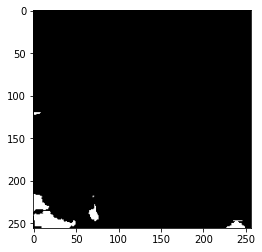

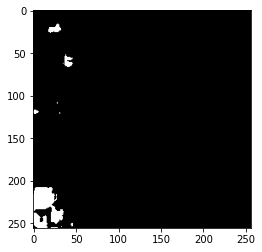

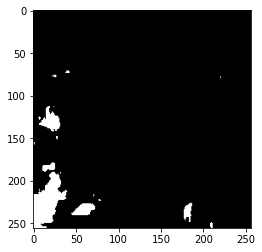

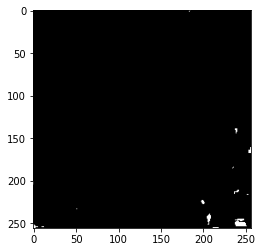

KeyboardInterrupt: 

In [101]:
for i in face_mags:
    plt.imshow(i.astype('uint8'),cmap='gray')
    plt.show()

In [83]:
frame[0].shape

(256, 3)

In [92]:

cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

array([[ 65,  68,  69, ..., 130, 130, 130],
       [ 45,  49,  49, ..., 130, 129, 129],
       [ 34,  32,  35, ..., 129, 128, 128],
       ...,
       [131, 150, 139, ...,  61,  66,  55],
       [131, 145, 141, ...,  29,  44,  42],
       [136, 155, 177, ...,  40,  40,  39]], dtype=uint8)

In [77]:
i[:,:,None].shape

(256, 256, 1)

In [17]:

#Save Videos
height, width,_ = original_frames[0].shape
video_name = f'created_videos/raw_video_{uuid_}.avi'
video = cv2.VideoWriter(video_name, 0, FPS, (width,height))

if SAVE_VIDEO:
    for i in original_frames:
        video.write(i)

        
        
left_of_frames = [cv2.resize(i,(114,114)) for i in left_of_frames]
right_of_frames = [cv2.resize(i,(114,114)) for i in right_of_frames]


#Save Videos
height = width = SIZE
video_name = f'created_videos/left_mouth_{uuid_}.avi'
video = cv2.VideoWriter(video_name, 0, FPS, (114,114))

if SAVE_VIDEO:
    for i in left_of_frames:
        video.write(i)


#Save Videos
height = width = SIZE
video_name = f'created_videos/right_mouth_{uuid_}.avi'
video = cv2.VideoWriter(video_name, 0, FPS, (114,114))

if SAVE_VIDEO:
    for i in right_of_frames:
        video.write(i)


error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'write'
> Overload resolution failed:
>  - image is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'image'


In [23]:
regions_flow['mouth']['left'].shape

(134, 77, 1)